In [1]:
# import packages

# numpy
import numpy                       as     np

# matplotlib
import matplotlib.pyplot           as     plt
import matplotlib                  as     mpl
import matplotlib.dates            as     mdates
from   matplotlib                  import rc
from   matplotlib.colors           import ListedColormap

# cartopy
import cartopy.crs                 as     ccrs
import cartopy.feature             as     cfeature
import cartopy.mpl.ticker          as     cticker
import cartopy.io.shapereader      as     shpreader

# shapely
import shapely.geometry            as     sgeom
from   shapely                     import geometry
from   shapely.ops                 import unary_union
from   shapely.geometry            import Polygon, Point, MultiPolygon
from   shapely.prepared            import prep

# scipy
from   scipy                       import interpolate
from   scipy.optimize              import fsolve
from   scipy.spatial               import KDTree
from   scipy.interpolate           import griddata

# data management packages
import xarray                      as     xr
import pandas                      as     pd
import geopandas                   as     gpd

# os
import os
import os.path

# remaining packages
import sys
import cmocean
import alphashape
import calendar
import fiona
import re
from   datetime                    import datetime
from   mpl_toolkits.axes_grid1     import make_axes_locatable
from   geographiclib.geodesic      import Geodesic
from   descartes                   import PolygonPatch
from   fastkml                     import kml

# Total distance
* Calculate the distance between the selected starting and destination locations.
* Create overview plot of locations and direct routes.
* Compile allowed rowing area

In [2]:
# starting locations
dfSloc = pd.DataFrame({'start_loc':["Fremantle","Geraldton","Kalbarri","Carnarvon","Exmouth" ,"Broome"  ],
                       'lat'      :[-32.056946 ,-28.782387 ,-27.711053,-24.883717 ,-21.930724,-17.951221],
                       'lon'      :[115.743889 ,114.607513 ,114.164536,113.656956 ,114.122389,122.244327]})

# destination locations
dfEloc = pd.DataFrame({'end_loc':["Dar es Salaam"],
                       'lat'    :[-6.766305      ],
                       'lon'    :[39.195973      ]})

tokts = 1.94384449 # convert m/s to kts

# calculate distances between starting and destination locations
lat1,lat2 = np.meshgrid(dfSloc.lat.values,dfEloc.lat.values) # combine latitudes start and destination locations
lon1,lon2 = np.meshgrid(dfSloc.lon.values,dfEloc.lon.values) # combine longitudes start and destination locations

def inverse_s12(lat1,lon1,lat2,lon2): # distance between locations [m]
    return Geodesic.WGS84.Inverse(lat1,lon1,lat2,lon2)['s12']
dis = np.vectorize(inverse_s12)(lat1,lon1,lat2,lon2) # distance between locations [m]
dfDis     = pd.DataFrame(np.swapaxes(dis,0,1)/1000,index=dfSloc.start_loc,columns=dfEloc.end_loc) # create dataframe - distance between locations [km]

# display dataframes
display(dfSloc)
display(dfEloc)
display(dfDis)

,start_loc,lat,lon
0,Fremantle,-32.056946,115.743889
1,Geraldton,-28.782387,114.607513
2,Kalbarri,-27.711053,114.164536
3,Carnarvon,-24.883717,113.656956
4,Exmouth,-21.930724,114.122389
5,Broome,-17.951221,122.244327


,end_loc,lat,lon
0,Dar es Salaam,-6.766305,39.195973


end_loc,Dar es Salaam
start_loc,
Fremantle,8349.927737
Geraldton,8233.916639
Kalbarri,8188.651414
Carnarvon,8135.141605
Exmouth,8184.562517
Broome,9054.516380


In [3]:
def pltbasesimple(xlims,xtickspacing,ylims,ytickspacing):
    fig   = plt.figure()
    ax    = plt.axes(projection=ccrs.PlateCarree()) # create axis

    ax.set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], ccrs.PlateCarree()) # set limits
    ax.add_feature(cfeature.LAND,facecolor=[0.95,0.95,0.95]) # add land
    ax.add_feature(cfeature.COASTLINE) # add coast
    
    ax = tickplacer(ax,xlims,xtickspacing,ylims,ytickspacing)
    return fig,ax

def create_domain(): # create allowed domain to row
    # define domain
    dom  = np.array([[40,-38],[35,-30],[35,-2],[95,-2],[102,-8],[113,-10],[122.5,-13.5],[122.5,-30],[115,-34],[110,-38]]) # coordinates domain
    pdom = geometry.Polygon([[p[0], p[1]] for p in dom]) # create polygon

    # remove certain zones
    dom_excl  = np.array([[49.6,-15.2],[50.42,-16.1],[49.84,-17.2],[49.11,-17.19]]) # small cove Madagascar 
    pdom_excl = geometry.Polygon([[p[0], p[1]] for p in dom_excl]) # create polygon
    pdom      = pdom.difference(pdom_excl) # remove from domain

    # remove land from zones
    land_shp_fname = shpreader.natural_earth(resolution='50m',category='physical', name='land') # load in land
    land_geom      = unary_union(list(shpreader.Reader(land_shp_fname).geometries())) # get geometry 
    pdom           = pdom.difference(land_geom) # remove from domain
    return pdom

def Geodesic2points(start_lat,start_lon,end_lat,end_lon,N=100): # geodesic line between two points
    gl = Geodesic.WGS84.InverseLine(start_lat,start_lon,end_lat,end_lon) # geodesic between the two points
    ea = np.linspace(0, gl.s13, N) # gl.s13 is the total length of the geodesic

    plon = np.empty(N) # allocate longitude
    plat = np.empty(N) # allocate latitude 

    for i in range(N): # loop over each point
        g  = gl.Position(ea[i], Geodesic.STANDARD | Geodesic.LONG_UNROLL) # get locations
        plon[i] = g['lon2']
        plat[i] = g['lat2']
    return plon,plat

def tickplacer(ax,xlims,xtickspacing,ylims,ytickspacing):
    # place x-ticks
    xticks,xticklabels = tickplacer_single_ax(xlims,xtickspacing)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticklabels)

    # place y-ticks
    yticks,yticklabels = tickplacer_single_ax(ylims,ytickspacing)
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_yticklabels(yticklabels)
    return ax

def tickplacer_single_ax(lims,tickstep,dropticksmid = False): # place ticks and labels for lon-lat plots
    ticks       = np.arange(np.ceil(lims[0]/tickstep)*tickstep,np.floor((lims[1])/tickstep+1)*tickstep,tickstep)
    tickstepstr = str(tickstep)
    ticksdec    = tickstepstr[::-1].find('.')
    if ticksdec < 0:
        ticksdec = 0
    ticklabels  = [("%."+str(ticksdec)+"f"+"$^\circ$") % number for number in ticks]
    if dropticksmid:
        ticklabels[1:-1] = [' '] * len(ticklabels[1:-1])
    
    return ticks,ticklabels # place ticks along axis

C:\Users\23513098\Anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\23513098\Anaconda3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


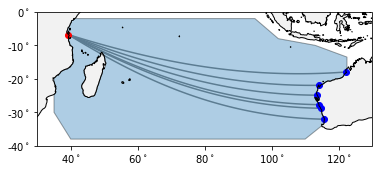

In [4]:
pdom = create_domain() # create allowed domain to row

# create figure of domain, including start and ending destinations
xlims = [30,130] 
ylims = [-40,0]
fig,ax = pltbasesimple(xlims,20,ylims,10)

[ax.add_patch(PolygonPatch(pdom.geoms[0], alpha=0.2)) for i in range(len(pdom.geoms))]

for i in range(len(dfSloc)): # loop over all starting locations
    start_loc = dfSloc.start_loc.iloc[i] 
    start_lat = dfSloc.lat.iloc[i]
    start_lon = dfSloc.lon.iloc[i]
    
    plt.scatter(start_lon,start_lat,color='blue') # add starting locations
    
for j in range(len(dfEloc)): # loop over all ending locations
    end_loc   = dfEloc.end_loc.iloc[j]
    end_lat   = dfEloc.lat.iloc[j]
    end_lon   = dfEloc.lon.iloc[j]
    
    plt.scatter(end_lon,end_lat,color='red') # add ending locations
    
    for i in range(len(dfSloc)): # loop over all starting locations
        start_lat       = dfSloc.lat.iloc[i]
        start_lon       = dfSloc.lon.iloc[i]
                    
        plon,plat = Geodesic2points(start_lat,start_lon,end_lat,end_lon,N=100) # calculate geodesic distance 
        plt.plot(plon,plat,color='grey',zorder=0,transform=ccrs.Geodetic()) # plot line
plt.show()

# Load hindcast data 
Load data of wind speeds, waves and currents. In addition, make overview plots per month of the hindcast. 

In [5]:
# load datasets
dswind  = xr.open_dataset('Data/CERSAT-GLO-REP_WIND_L4-OBS_FULL_TIME_SERIE_1648775425193.nc').load()
dswaves = xr.open_dataset('Data/cmems_obs-wave_glo_phy-swh_my_multi-l4-2deg_P1D_1648776708969.nc').load()
dswater = xr.open_dataset('Data/nemo_monthly_mean.nc').load()

# correct wind dataset (wrong direction of winds)
dswind = dswind.rename_vars(eastward_wind   = 'northward_wind1')
dswind = dswind.rename_vars(northward_wind  = 'eastward_wind')
dswind = dswind.rename_vars(northward_wind1 = 'northward_wind')

In [74]:
def pimshow(X,Y,Z,ax=None,*args,**kwargs):
    dx = (X[0,1]-X[0,0])/2.
    dy = (Y[1,0]-Y[0,0])/2.
    extent = [X[0,0]-dx, X[0,-1]+dx, Y[0,0]-dy, Y[-1,0]+dy]
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(np.flip(Z,axis=0), extent=extent,*args,**kwargs)    
    
    if 'vmin' in kwargs.keys(): # plot colorbar
        cax  = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
        zmin = np.nanmin(z)
        zmax = np.nanmax(z)

        if (zmin>=kwargs['vmin']) & (zmax<=kwargs['vmax']):
            extend = 'neither'
        elif (zmax>kwargs['vmax']) & (zmin<kwargs['vmin']):
            extend = 'both'
        elif zmax>kwargs['vmax']:
            extend = 'max'
        elif zmin<kwargs['vmin']:
            extend = 'min'
        plt.colorbar(im,cax=cax,extend=extend)
    return im

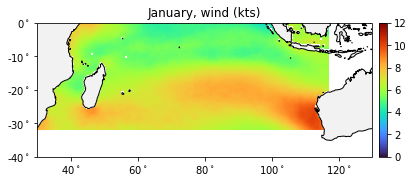

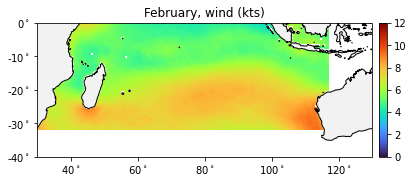

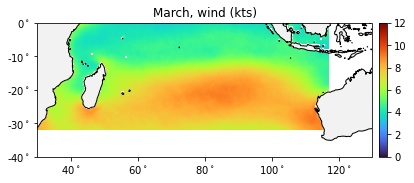

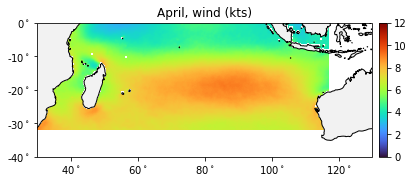

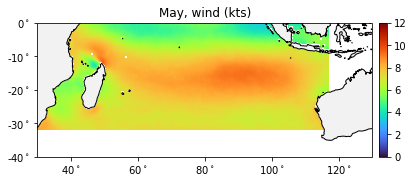

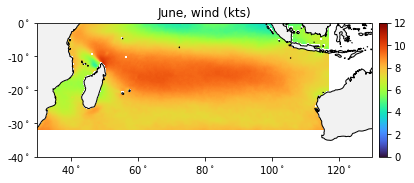

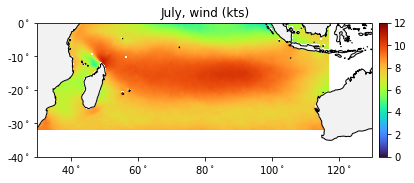

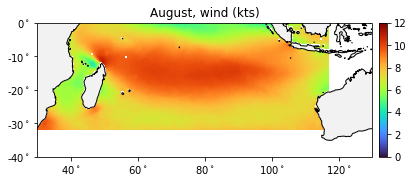

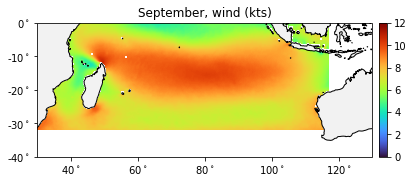

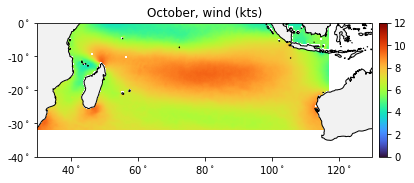

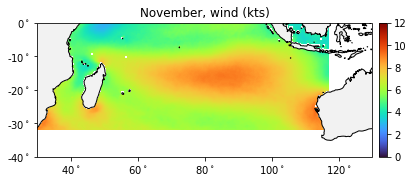

In [79]:
# plot average wind speed per month
for nmonth in range(1,12):
    lat  = dswind.latitude.values
    lon  = dswind.longitude.values
    x,y  = np.meshgrid(lon,lat)
    t    = dswind.time.values
    tidx = (t.astype('datetime64[M]').astype(int) % 12 + 1)==nmonth
    ua   = np.mean(dswind.northward_wind[tidx,0,:,:].values,axis=0)*tokts
    va   = np.mean(dswind.eastward_wind[tidx,0,:,:].values,axis=0)*tokts
    z    = np.mean(dswind.wind_speed[tidx,0,:,:],axis=0)

    idx = 15 # quiver step
    fig,ax = pltbasesimple(xlims,20,ylims,10)
    im = pimshow(x,y,z,ax,cmap='turbo',interpolation='bilinear',vmin=0,vmax=12)
    plt.quiver(x[::idx,::idx],y[::idx,::idx],ua[::idx,::idx],va[::idx,::idx],units='xy',scale_units='xy',scale=3)
    ax.set(xlim=xlims,ylim=ylims,title=calendar.month_name[nmonth]+', wind (kts)')
    plt.show()

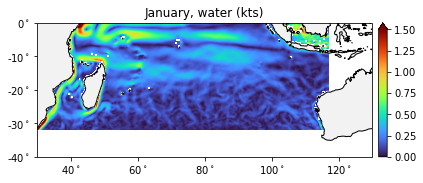

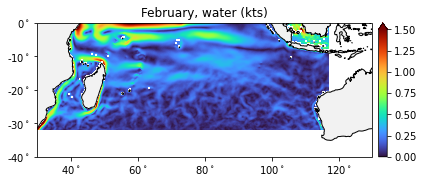

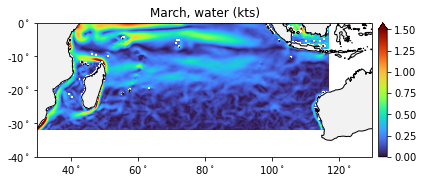

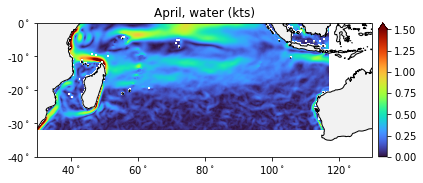

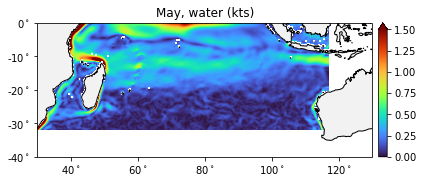

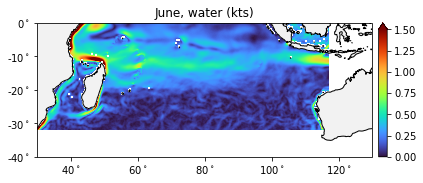

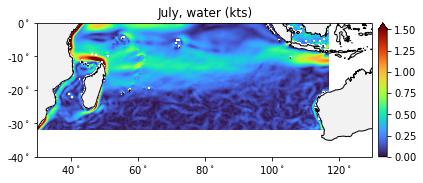

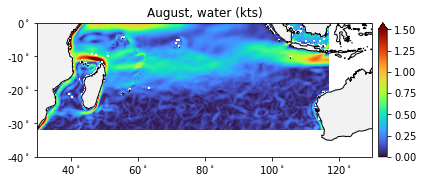

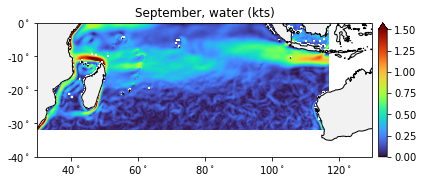

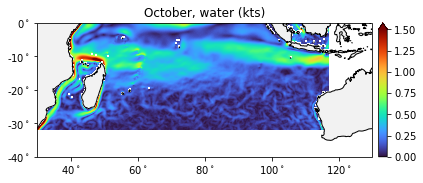

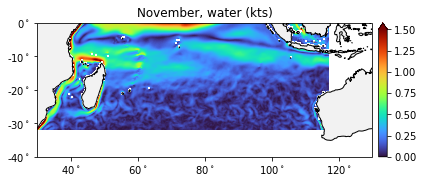

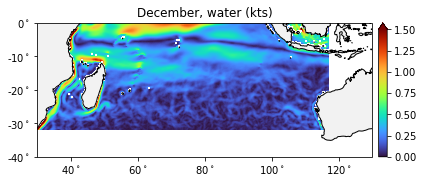

In [78]:
# plot average current speed per month
for nmonth in range(1,13):
    lat  = dswater.latitude.values
    lon  = dswater.longitude.values
    x,y  = np.meshgrid(lon,lat)
    t    = dswater.time.values
    tidx = (t.astype('datetime64[M]').astype(int) % 12 + 1) == nmonth
    uw   = np.mean(dswater.uo[tidx,0,:,:].values,axis=0)*tokts
    vw   = np.mean(dswater.vo[tidx,0,:,:].values,axis=0)*tokts
    z    = np.sqrt(uw**2+vw**2)

    idx = 30 # quiver step
    fig,ax = pltbasesimple(xlims,20,ylims,10)
    im = pimshow(x,y,z,ax,cmap='turbo',interpolation='bilinear',vmin=0,vmax=1.5)
    plt.quiver(x[::idx,::idx],y[::idx,::idx],uw[::idx,::idx],vw[::idx,::idx],units='xy',scale_units='xy',scale=0.2)
    ax.set(xlim=xlims,ylim=ylims,title=calendar.month_name[nmonth]+', water (kts)')
    plt.show()

C:\Users\23513098\AppData\Local\Temp\ipykernel_9768\1812675527.py:10: RuntimeWarning: Mean of empty slice
  z  = np.nanmean(dswaves.VAVH_DAILY_MAX[tidx,:,:].values,axis=0)


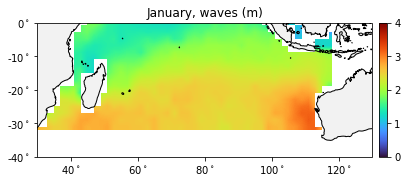

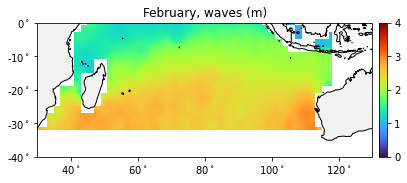

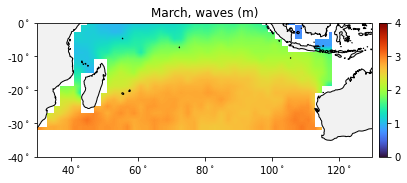

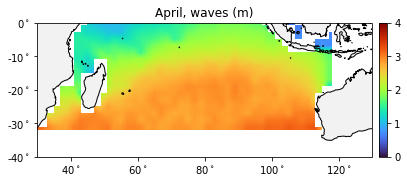

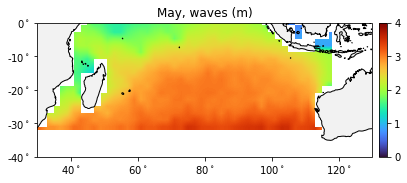

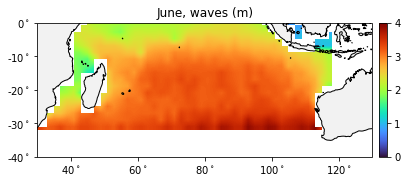

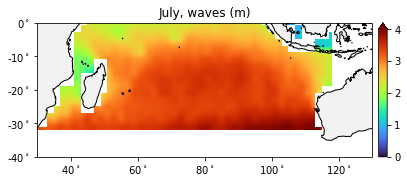

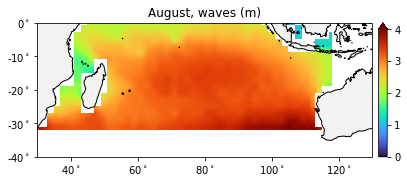

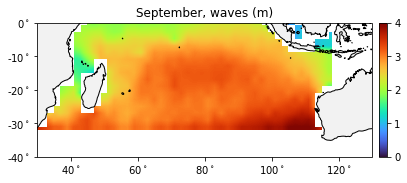

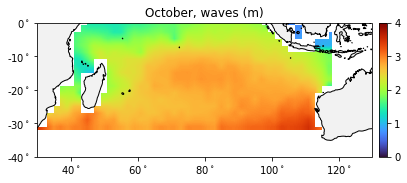

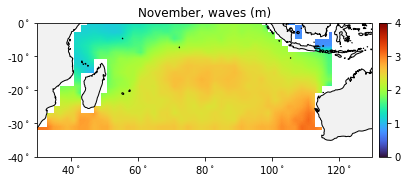

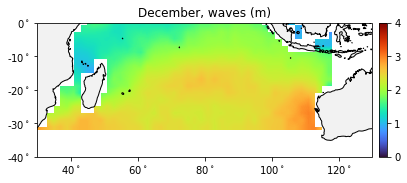

In [77]:
# plot average daily maximum wave height per month
for nmonth in range(1,13):
    lat  = dswaves.latitude.values
    lon  = dswaves.longitude.values
    x,y  = np.meshgrid(lon,lat)
    t    = dswaves.time.values
    tidx = (t.astype('datetime64[M]').astype(int) % 12 + 1)==nmonth
    z    = np.nanmean(dswaves.VAVH_DAILY_MAX[tidx,:,:].values,axis=0)

    fig,ax = pltbasesimple(xlims,20,ylims,10)
    pimshow(x,y,z,ax,cmap='turbo',interpolation='bilinear',vmin=0,vmax=4)
    ax.set(xlim=xlims,ylim=ylims,title=calendar.month_name[nmonth]+', waves (m)')
    plt.show()

# Model forces

<span style="color:red">The used boat specifications are incorrect and should be updated.</span>

In [80]:
def total_force(V,*arg): # calculate sum of forces on rowing boat
    Vw,Va,ed,Frmag,row,anc,Gw,GwA,Ga = arg # fill in arguments

    # rowing force 
    Fr  = int(row)*Frmag*ed

    # water friction sea anchor    
    Fwterm = np.sqrt((Vw-V).dot(Vw-V))*(Vw-V)
    Fw     = Gw*Fwterm # water friction
    Fwa    = int(anc)*GwA*Fwterm # sea anchor water friction, anchor is in when resting (row = 0)

    # air friction 
    Fa  = Ga*np.sqrt((Va-V).dot(Va-V))*(Va-V)
    Fap = Fa.dot(ed)*ed # parallel component

    # total force
    return Fw + Fwa + Fap + Fr

def plttarject(fig,ax,Nhist,Xs,Xt,hide_all = False, hide_fast = False, traj_col = False): # plot trajectories 
    Nsteps = len(Nhist)-1 # number iterations

    if (hide_all == False):
        
        if traj_col:
            cmap    = ListedColormap(plt.get_cmap('viridis',Nsteps)(np.linspace(0,1,Nsteps)))
            cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
            sm = plt.cm.ScalarMappable(cmap=cmap,norm = mpl.colors.Normalize(vmin=0,vmax=(datet-datet0).days))
            sm.set_array([])
            plt.colorbar(sm,cax=cax)

            
        for i in range(Nsteps): # loop over every step
            Nhisti = Nhist[Nsteps-i] # get idx of previous points
            Xs1    = Xs[Nsteps-i] # location current point
            Xs0    = Xs[Nsteps-i-1][Nhisti] # location previous point
            
            Ni     = Xs1.shape[0] # get number of points in step
            
            if traj_col == False:
                for j in range(Ni): # loop over all points
                    ax.plot([Xs0[j,0],Xs1[j,0]],[Xs0[j,1],Xs1[j,1]],color='black',linewidth=0.5) # plot line between points
            else:
                for j in range(Ni): # loop over all points
                    ax.plot([Xs0[j,0],Xs1[j,0]],[Xs0[j,1],Xs1[j,1]],color=cmap(Nsteps-i)[0:3],linewidth=1) # plot line between points

        
    if hide_fast == False:
        rto  = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xs[-1]]) # distance to target 
        iwin = np.argmin(rto) # find point closest to target

        Xawin           = np.empty([Nsteps+1,2]) # allocate coordinates of this line
        Xawin[Nsteps,:] = Xs[Nsteps][iwin,:] # fill in last coordinate

        for i in range(Nsteps): # loop over all steps
            Nhisti            = Nhist[Nsteps-i] # find previous coordinate
            iwin              = Nhisti[iwin] # update idx
            Xawin[Nsteps-1-i] = Xs[Nsteps-i-1][iwin] # include coordinate

        ax.plot(Xawin[:,0],Xawin[:,1],'-',color='red',linewidth=2) # draw fastest route
    return fig,ax


Ratio Ga/Gw  = 0.0400
Rowing force = 42.28 N
Rowing power = 43.50 W
Velocity (0 Kts, no waves and currents)   = 2.00 Kts
Velocity (+25 Kts, no waves and currents) = 4.57 Kts
Velocity (-25 Kts, no waves and currents) = -3.73 Kts


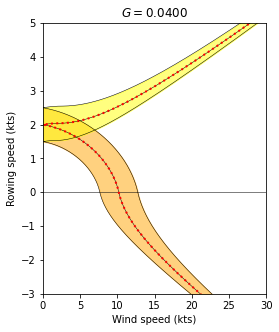

In [81]:
# boat specifications
m     = 670 # wiegth [kg]

# water friction - boat
rhow  = 1024 # density water [kg/m^3]
Aw    = 15 # frontal area exposed to water
Cdw   = 0.005 # friction coef. water 
Gw    = rhow*Cdw*Aw/2 # water friction constant

# water friction - anchor
GwA   = 50*Gw # water friction constant sea anchor

# air friction 
rhoa  = 1.225 # density air [kg/m^3]
Aa    = 2 # frontal area exposed to air
Cda   = 0.04*Gw/(0.5*rhoa*Aa) # friction coef. air 
Ga    = rhoa*Cda*Aa/2 # air friction constant

# friction ratio boat
G     = Ga/Gw # ratio of air friction cosntant to water friction constant

# calculate force from velocity in perfect conditions
vperf = 2/tokts # boat velocity in perfect conditions [m/s]
Frmag = (Ga+Gw)*vperf**2 # calculate rowing force magnitude from perfect conditions [N]
Pr    = Frmag*vperf # rowing power [W]

# calculate rowing velocity for head and tail winds (no currents and waves)
def vrowfromvair(Ga,Gw,Frmag,vair):
    # calculate the rowing velocity depending on the head and tail wind
    vaireqvrow =  np.sqrt(Frmag/Gw) # no head or tail wind
    vairrow0   = -np.sqrt(Frmag/Ga) # no boat velocity
    
    if vair > vaireqvrow:
        vrow = (-vair*Ga+np.sqrt(Frmag*(Gw-Ga)+vair**2*Ga*Gw))/(Gw-Ga)
    elif vair == vaireqvrow:
        vrow = vaireqvrow
    elif (vair < vaireqvrow) & (vair > vairrow0):
        vrow = (vair*Ga+np.sqrt(Frmag*(Gw+Ga)-vair**2*Ga*Gw))/(Gw+Ga)
    elif vair == vairrow0:
        vrow = 0
    elif vair < vairrow0:
        vrow = (-vair*Ga-np.sqrt(Frmag*(Ga-Gw)+vair**2*Ga*Gw))/(Gw-Ga)
    return vrow
def vrowfromvair2(G,v0,vair):
    # calculate the rowing velocity depending on the head and tail wind
    vaireqvrow =  np.sqrt(1+G)*v0 # no head or tail wind
    vairrow0   = -np.sqrt(1+1/G)*v0  # no boat velocity
    
    if vair > vaireqvrow:
        vrow = (G*vair-np.sqrt(G*vair**2-(G**2-1)*v0**2))/(G-1)
    elif vair == vaireqvrow:
        vrow = vaireqvrow
    elif (vair < vaireqvrow) & (vair > vairrow0):
        vrow = (G*vair+np.sqrt((G+1)**2*v0**2-G*vair**2))/(G+1)
    elif vair == vairrow0:
        vrow = 0
    elif vair < vairrow0:
        vrow = (G*vair+np.sqrt((G**2-1)*v0**2+G*vair**2))/(G-1)
    return vrow

# provide overview of velocity and friction
print("Ratio Ga/Gw  = {:.4f}".format(G))
print("Rowing force = {:.2f} N".format(Frmag))
print("Rowing power = {:.2f} W".format(Pr))
print("Velocity (0 Kts, no waves and currents)   = {:.2f} Kts".format(vperf*tokts))
print("Velocity (+25 Kts, no waves and currents) = {:.2f} Kts".format(vrowfromvair(Ga,Gw,Frmag,+25/tokts)*tokts))
print("Velocity (-25 Kts, no waves and currents) = {:.2f} Kts".format(vrowfromvair(Ga,Gw,Frmag,-25/tokts)*tokts))

def plotvrowfromvair(G,tokts,vperf): # plot velocity depending on head and tail wind
    vperfmin = vperf+0.5/tokts
    vperfmax = vperf-0.5/tokts
       
    vairr       = np.linspace(-30,30,1000)/tokts
    vrowairr    = np.empty(len(vairr))
    vrowairrN   = np.empty(len(vairr))
    vrowairrmin = np.empty(len(vairr))
    vrowairrmax = np.empty(len(vairr))
    
    vaireqvrow =  np.sqrt(1+G)*vperf # no head or tail wind
    vairrow0   = -np.sqrt(1+1/G)*vperf  # no boat velocity
    
    for i in range(len(vairr)):
        
        vrowairr[i]    = vrowfromvair2(G,vperf,vairr[i])
        vrowairrmin[i] = vrowfromvair2(G,vperfmin,vairr[i])
        vrowairrmax[i] = vrowfromvair2(G,vperfmax,vairr[i])
        
        vrowairrN[i] = fsolve(total_force,list((vperf+vairr[i]*0.1)*np.array([1,0])),args=(np.array([0,0]),np.array([vairr[i],0]),np.array([1,0]),Frmag,True,False,Gw,GwA,Ga))[0]

    fig, ax = plt.subplots(figsize=(4,4*14.25/11.45))
     
    plt.axhline(y=0, color='black', linestyle='-',linewidth=0.5)
    
    plt.fill_between(np.abs(vairr[vairr<=0])*tokts, vrowairrmin[vairr<=0]*tokts,vrowairrmax[vairr<=0]*tokts,color='orange', alpha=0.5)
    plt.fill_between(np.abs(vairr[vairr>=0])*tokts, vrowairrmin[vairr>=0]*tokts,vrowairrmax[vairr>=0]*tokts,color='yellow', alpha=0.5)
    plt.plot(np.abs(vairr*tokts),vrowairrmin*tokts,color='black',linewidth=0.5)
    plt.plot(np.abs(vairr*tokts),vrowairrmax*tokts,color='black',linewidth=0.5)
    plt.plot(np.abs(vairr*tokts),vrowairr   *tokts,color='black',linewidth=0.5)
    plt.plot(np.abs(vairr*tokts),vrowairrN  *tokts,':',color='red',linewidth=2)
    
    plt.xlim([0,np.max(np.abs(vairr))*tokts])
    plt.ylim([-3,5])
    plt.title("$G = {:.4f}$ ".format(G))
    plt.xlabel("Wind speed (kts)")
    plt.ylabel("Rowing speed (kts)")
    
    plt.savefig(os.getcwd()+'\\Plots'+'\\'+'rowspeed VS windspeed - '+'$G = {:.4f}$ '.format(G)+'.png', dpi=300, bbox_inches='tight')
    pass 

%matplotlib inline
plotvrowfromvair(G,tokts,vperf)

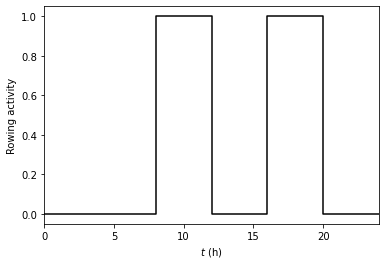

In [82]:
tod_start = ['08:00:00','16:00:00'] # start rowing - time of day
tod_stop  = ['12:00:00','20:00:00'] # stop rowing - time of day

def interval_activity(tod_start,tod_stop):
    # split day into intervals
    int0row   = np.array(pd.to_timedelta(tod_start).total_seconds()).astype(int) # start rowing [s]
    int0rest  = np.array(pd.to_timedelta(tod_stop).total_seconds()).astype(int) # start resting [s]
    int0      = np.append(int0row,int0rest) # interval starting times (both rowing and resting) [s]
    introw    = np.append(np.ones(int0row.shape).astype(bool),np.zeros(int0rest.shape).astype(bool)) # activity (True = rowing, False = resting)

    order     = np.argsort(int0) # sort intervals in time
    int0      = int0[order] # sort starting times [s]
    introw    = introw[order] # sort activity [bool]
    intdur    = np.diff(np.append(int0,24*3600+int0[0])) # calculate interval duration [s]
    intN      = len(int0) # total number of intervals per day
    return int0,introw,intdur,intN
    
int0,introw,intdur,intN = interval_activity(tod_start,tod_stop)

# plot rowing activity as function of time of day
fig,ax = plt.subplots()
plt.step(np.append(np.append(0,int0),3600*24)/(3600),np.append(np.append(introw[-1],introw),introw[-1]),where='post',color='black')
ax.set_xlim([0,24])
ax.set_ylabel('Rowing activity')
ax.set_xlabel('$t$ (h)')
plt.show()
plt.close()

In [89]:
def filter2Dangleint(Xa,Xt,Np,keepsides=True,geo=False):
    NXa = Xa.shape[0] # number of points
    if NXa>Np: # apply this function if there are more points then requested segments

        Xa0 = Xa-Xt # set Xt as (0,0)
           
        
        if geo:
            dis = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa]) # calculate distance to target    
            phi = np.array([Geodesic.WGS84.Inverse(Xt[1],Xt[0],x[1],x[0])['azi1']/180*np.pi for x in Xa]) # calculate from target
        else:
            dis = np.sqrt(Xa0[:,0]**2+Xa0[:,1]**2) # calculate distance to target 
            phi = np.arctan2(Xa0[:,1],Xa0[:,0])+np.pi # calculate from target
        
        phis    = np.sort(phi)
        phis2   = np.append(phis,phis+2*np.pi)
        idxmdif = np.argmax(np.diff(phis2)[:NXa])

        if idxmdif == NXa-1:
            phimin = phis[0]
            phimax = phis[idxmdif]

            phinmin = 0
            phinmax = phimax-phimin

            phin = phi-phimin
            phin[phin< 0] += 2*np.pi
            phin[phin> 2*np.pi] -= 2*np.pi
        else:
            phimin = phis[idxmdif+1]
            phimax = phis[idxmdif]

            phinmin = 0
            phinmax = 2*np.pi-(phimin-phimax)

            phin = phi-phimin
            phin[phin< 0] += 2*np.pi
            phin[phin> 2*np.pi] -= 2*np.pi

        Nseg  = Np
        Nsegd = 0 
                   
        while Nsegd < Np: 
            binedge            = np.linspace(0,phinmax,Nseg+1)   

            inds = np.digitize(phin,binedge)-1
            inds[inds>(Nseg-1)] = Nseg-1

            indsunq = np.unique(inds)
            Nsegd   = len(indsunq)
            
            if Nsegd < Np:
                Nseg += 1
                
                
        idxkeep = np.zeros(NXa).astype(bool)

        for i in range(Nsegd):
            indsi = indsunq[i]
            idx   = inds == indsi
            Xa0i  = Xa0[idx,:]
            disi  = dis[idx]
            idxmin = np.argmin(disi)
            idxkeep[np.where(idx)[0][idxmin]] = True
        if keepsides:
            idxkeep[np.argmax(phin)] = True
            idxkeep[np.argmin(phin)] = True

        Xa0b = Xa0[idxkeep]
        Xaf  = Xa0b+Xt
    else:
        Xaf = Xa 
        idxkeep = np.ones(NXa).astype(bool)
    return Xaf,idxkeep
def AlphaShapeOpt(points2d,**kwargs):
    # get single alpha shape without outliers
    # points2d: points in 2D (N,2)
    # alpha_step: increase alpha from 0 by alpha_step each iteration
    
    keys = kwargs.keys()
    
    if 'alpha_step' in keys:
        alpha_step = kwargs['alpha_step']
    else:
        alpha_step = 0.1
        
    if 'fix_alpha' in keys:
        fix_alpha = kwargs['fix_alpha']
    else:
        fix_alpha = None


    if fix_alpha == None:
        alpha = 0 # intialize alpha
        alpha_shape = alphashape.alphashape(points2d, alpha) # get alpha shape

        polytype = type(alpha_shape).__name__ # get type of shape
        all_in   = np.all(np.array([Point(points2d[i,:]).intersects(alpha_shape) for i in range(points2d.shape[0])])) # check if all points are intersecting with shape

        flag = False # track if alpha increased

        # start increasing alpha while making sure there remains only one shape and all point remaing intersecting
        while (polytype == 'Polygon') & (all_in == True): # check if conditions hold
            alpha      += alpha_step # increase alpha
            flag        = True 
            alpha_shape = alphashape.alphashape(points2d, alpha) # create new alpha shape
            polytype    = type(alpha_shape).__name__ # check type
            all_in      = np.all(np.array([Point(points2d[i,:]).intersects(alpha_shape) for i in range(points2d.shape[0])])) # check points intersecting shape
        if flag:
            alpha      -= alpha_step # remove one step of alpha 
            alpha_shape = alphashape.alphashape(points2d, alpha) # get alpha shape
    else:
            alpha      = fix_alpha # set alpha equal to fix_alpha (given as optional input)
            alpha_shape = alphashape.alphashape(points2d, alpha) # get alpha shape

    idx     = np.array([Point(points2d[i,:]).touches(alpha_shape) for i in range(points2d.shape[0])])
    border  = points2d[idx] # get outline coordinates of shape
    shape   = alpha_shape # get shape
    return border,idx,shape
def hindcast_slice_data(datet):  
    Dadatetidx = np.argmin(np.abs(Dadatet-datet.to_datetime64()))  

    Dua = dswind.northward_wind[Dadatetidx,0,:,:].values
    Dva = dswind.eastward_wind [Dadatetidx,0,:,:].values

    Dwdatet    = dswater.time.values
    Dwdatetidx = np.argmin(np.abs(Dwdatet-datet.to_datetime64())) 

    Duw = dswater.uo[Dwdatetidx,0,:,:].values
    Dvw = dswater.vo[Dwdatetidx,0,:,:].values
      
    return Dua,Dva,Duw,Dvw
def hindcast_get_vel(Dua,Dva,Duw,Dvw,X):    
    # air velocity
    Dalatidx = np.argmin(np.abs(Dalat-X[1]))
    Dalonidx = np.argmin(np.abs(Dalon-X[0]))

    ua = Dua[Dalatidx,Dalonidx]
    va = Dva[Dalatidx,Dalonidx]
    Va = np.array([ua,va])

    if np.any(np.isnan(Va)): 
        Va = np.array([0,0])

    # water velocity
    Dwlatidx = np.argmin(np.abs(Dwlat-X[1]))
    Dwlonidx = np.argmin(np.abs(Dwlon-X[0]))

    uw = Duw[Dwlatidx,Dwlonidx]
    vw = Dvw[Dwlatidx,Dwlonidx]
    Vw = np.array([uw,vw])

    if np.any(np.isnan(Vw)): 
        Vw = np.array([0,0])
    return Va,Vw

def interval0(datet0,int0): # calculate idx and duration of starting interval
    intdur = np.diff(np.append(int0,24*3600+int0[0])) # calculate interval duration [s]
    intN   = len(int0) # total number of intervals per day
    t0     = int((datet0-pd.to_datetime(datet0.date())).total_seconds()) # starting time [second of day]
    if t0<int0[0]: # if in interval that started the day before and runs in the next day
        k0  = intN-1 # interval index
        dt0 = int0[0]-t0 # timestep till next interval
    else:
        k0  = np.where(int0<=t0)[0][-1] # interval index
        dt0 = intdur[k0]-(t0-int0[k0]) # timestep till next interval
    return k0,dt0

def pltbaseoverview(X0,Xt,**kwargs): # create base of plot
    keys = kwargs.keys()
    
    if 'title' in keys:
        title = kwargs['title']
    else:
        title = ' '
        
    fig   = plt.figure()
    ax    = plt.axes(projection=ccrs.PlateCarree())
    xlims = [30,130] 
    ylims = [-40,0]
    ax.set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], ccrs.PlateCarree()) # set limits
    ax.add_feature(cfeature.LAND,facecolor=[0.95,0.95,0.95]) # add land
    ax.add_feature(cfeature.COASTLINE) # add coast
    ax.set(**{'xlim':xlims,'ylim':ylims,'aspect':1,'title':title})

    # plot lines
    ax.scatter(X0[0],X0[1] ,50,color='blue') # 
    ax.scatter(Xt[0],Xt[1] ,50,color='red')
    plon,plat = Geodesic2points(X0[1],X0[0],Xt[1],Xt[0],N=100) # calculate geodesic distance 
    plt.plot(plon,plat,'--',color='grey',zorder=0) # plot geodesic distance 
    fig.canvas.draw()
    return fig,ax

def angle_between(p1, p2): # calculate angle between two points
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

<IPython.core.display.Javascript object>


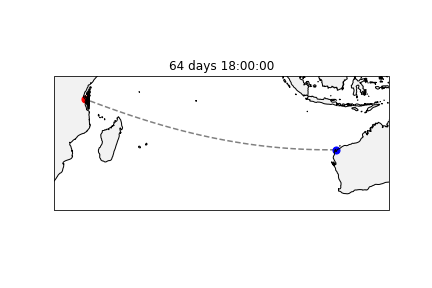

C:\Users\23513098\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\23513098\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\23513098\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [90]:
start_loc = 'Exmouth' # starting location
end_loc   = 'Dar es Salaam' # target location

# calculate force from velocity in perfect conditions
vperf = 2/tokts # boat velocity in perfect conditions [m/s]
Frmag = (Ga+Gw)*vperf**2 # calculate rowing force magnitude from perfect conditions [N]
Pr    = Frmag*vperf # rowing power [W]

# start location
lon0   = dfSloc[dfSloc.start_loc==start_loc].lon.item()
lat0   = dfSloc[dfSloc.start_loc==start_loc].lat.item()
X0     = np.array([lon0,lat0])

# target
latt   = dfEloc[dfEloc.end_loc==end_loc].lat.item()
lont   = dfEloc[dfEloc.end_loc==end_loc].lon.item()
Xt     = np.array([lont,latt])
rt0    = Geodesic.WGS84.Inverse(X0[1],X0[0],Xt[1],Xt[0])['s12'] # distance to target

# load land map
land_shp_fname = shpreader.natural_earth(resolution='50m',category='physical', name='land') # load in land
land_geom      = unary_union(list(shpreader.Reader(land_shp_fname).geometries())) # get geometry 
land           = prep(land_geom) # get land

# row activity
tod_start = ['06:00:00'] # start rowing - time of day
tod_stop  = ['18:00:00'] # stop rowing - time of day
int0,introw,intdur,intN = interval_activity(tod_start,tod_stop)

# time series
rtmin  = np.max([np.max(intdur[introw])*vperf*1.5,50000]) # min distance to target [m]
imax   = 1000 # maximum number of iterations
datet0 = pd.Timestamp('2018-04-01 00:00:00') # starting datetime

# row activity
jstep  = 1 # store values after every jstep
datets = np.empty([int(np.ceil(imax/jstep))]) # allocate to store time
datets.fill(np.nan) 
 
# intialize 
N       = 1; # number of starting points
Nr      = np.arange(0,N).astype(int) # make range of starting points
Xa      = np.empty([N,2]) # allocate all locations
Xa[0,:] = X0 # location 
i       = 0 # iteration
j       = 0 # storage iteration
k,dt    = interval0(datet0,int0) # k: idx interval, dt: timestep interval
rto     = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa]) # geodesic distance to target
datet   = datet0 # datetime series

# rowing directions 
phir   = np.linspace(-90,90,9) # angle offsets to target
Nphir  = len(phir) # number of angle offsets

# dataset coordinates
Dalat   = dswind.latitude.values
Dalon   = dswind.longitude.values
Dwlat   = dswater.latitude.values
Dwlon   = dswater.longitude.values
Dadatet = dswind.time.values

# load hindcast data 
Dua,Dva,Duw,Dvw = hindcast_slice_data(datet) # get slice of hindcast air and water velocities
Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X0) # get air and water velocities at location of boat

# store variables
Xs     = []; Xs.append(Xa)
Vas    = []; Vas.append(np.array([Va]))
Vws    = []; Vws.append(np.array([Vw]))
Vs     = []; Vs.append(np.array([[np.nan,np.nan]]))
datets = []; datets.append(datet.to_numpy())
Nhist  = []; Nhist.append(None)

# create plot
%matplotlib notebook
fig,ax = pltbaseoverview(X0,Xt,title = pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
pltraj = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)

while (i < (imax-1)) & np.all(rto > rtmin): # start loop
    i = i+1  # next iteration
    
    # rowing activity
    rowt = introw[k] # check rowing activity options
    if rowt == True: # if rowing
        No   = Nphir+2 # can row (Nphir options) or rest(2 options: with and without anchor)
        phio = np.append(phir,[np.nan,np.nan]) # rowing direction options
        rowo = np.append(np.tile(True,Nphir),[False,False]) # rowing options
        anco = np.append(np.tile(False,Nphir),[False,True]) # anchor options
    if rowt == False: # if resting
        No   = 2 # 2 options: with and without anchor
        phio = np.array([np.nan,np.nan]) # rowing direction options
        rowo = np.array([False,False]) # rowing options
        anco = np.array([False,True]) # anchor options
    
    # allocate all new locations and velocities per time step
    Xaold  = Xa 
    Xa     = np.empty([N*No,2])
    Vai    = np.empty([N*No,2])
    Vwi    = np.empty([N*No,2])
    Vi     = np.empty([N*No,2])
    Nhisti = np.zeros([N*No]).astype(int)
    
    # load hindcast data 
    Dua,Dva,Duw,Dvw = hindcast_slice_data(datet) # get slice of hindcast air and water velocities
    
    for ii in range(N): # loop over every starting location  
        X = np.copy(Xaold[ii,:]) # get starting location
        
        # air and water velocity
        Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X) # get air and water velocities at location of boat
        
        for jj in range(No): # loop over every activity option
           
            Nhisti[ii*No+jj] = Nr[ii] # get starting point idx
            
            # get option details
            phi = phio[jj] 
            row = rowo[jj]
            anc = anco[jj]
        
            # direction
            if row: # when rowing
                theta  = Geodesic.WGS84.Inverse(X[1],X[0],Xt[1],Xt[0])['azi1'] # row in direction of destination (bearing geodesic)
                theta += phi # deviate from direction
                ed     = np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])
            else: # when resting 
                if Va.dot(Va)!=0: # if there is wind
                    ed    = Va/np.sqrt(Va.dot(Va)) # boat turns in direction of wind
                else: # if there is no wind
                    theta = Geodesic.WGS84.Inverse(X[1],X[0],Xt[1],Xt[0])['azi1'] # in direction of destination (bearing geodesic)
                    ed    = np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])

            # calculate boat velocity
            V = fsolve(total_force,list(ed*(vperf*int(row)+Vw*0.2+Va*0.1)),args=(Vw,Va,ed,Frmag,row,anc,Gw,GwA,Ga))

            # update velocity and position
            vmag = np.sqrt(V[0]**2+V[1]**2)
            if vmag != 0: # only update X if there is a V
                azi1 = angle_between([0,1],V)
                s12  = vmag*dt
                Xnew = np.array(list(map(Geodesic.WGS84.Direct(X[1],X[0],azi1,s12).get, ['lon2','lat2']))) # new location
            else:
                Xnew = np.copy(X)
                
            # get distances from start and end
            r0 = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],X0[1],X0[0])['s12'] # distance to starting point
            rt = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],Xt[1],Xt[0])['s12'] # distance to target point
      
            if np.logical_not(Point([Xnew[0],Xnew[1]]).intersects(pdom)) & (r0 > rtmin) & (rt > rtmin): #if on land
                Xnew  = np.array([np.nan,np.nan])
            else: # if in allowed region
                Xnew  = Xnew    
                
            # store values
            Xa [ii*No+jj,:] = Xnew 
            Vai[ii*No+jj,:] = Va
            Vwi[ii*No+jj,:] = Vw
            Vi [ii*No+jj,:] = V

    # filter new locations
    idx = np.ones(N*No).astype(bool)
    
    # remove NaN values 
    keepidx = np.logical_not(np.any(np.isnan(Xa[idx]),axis=1))
    idx[np.where(idx)[0][~keepidx]] = False
    
    # drop duplicates 
    _,idxuniq = np.unique(Xa[idx],axis=0,return_index=True)
    keepidx   = np.zeros(len(Xa[idx])).astype(bool)
    keepidx[idxuniq] = True
    idx[np.where(idx)[0][~keepidx]] = False
    
    # select points close to target (bin by anlge with target)
    _,keepidx = filter2Dangleint(Xa[idx],Xt,100,keepsides=True,geo=True)
    idx[np.where(idx)[0][~keepidx]] = False
    Xa     = Xa[idx,:]
    Nhisti = Nhisti[idx]
    Vai    = Vai[idx,:]
    Vwi    = Vwi[idx,:]
    Vi     = Vi[idx,:]
        
    # distance to target
    rto = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa])# geodesic distance to target
    N   = Xa.shape[0]
    Nr  = np.arange(0,N)
    
    # update datet
    datet = datet+pd.to_timedelta(dt,'s')   

    # store values
    Xs   .append(Xa)
    Nhist.append(Nhisti)
    Vas  .append(Vai)
    Vws  .append(Vwi)
    Vs   .append(Vi)
    datets.append(datet.to_numpy())
    
    # for next step
    k  = (k+1)%intN
    dt = intdur[k]
    
    print('Iteration: '+str(round(i/imax*1000)/10)+'%, Distance: '+str(round((1-np.min(rto)/rt0)*1000)/10)+'%', end='\r')

    if i%5 == 0: # plot locations
        pltrajpop = pltraj.pop(0)
        pltrajpop.remove()
        pltraj    = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)
        fig.canvas.draw()
        ax.set_title(pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
plt.show()

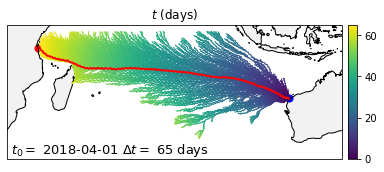

In [91]:
# plot trajectories as function of time
%matplotlib inline
titlem = '$t_0 = $ '+datet0.strftime('%Y-%m-%d')+' $\Delta t = $ '+str((datet-datet0).days)+' days'
fig,ax = pltbaseoverview(X0,Xt,title = '$t$ (days)')
fig,ax = plttarject(fig,ax,Nhist,Xs,Xt,hide_all = False, hide_fast = False, traj_col = True)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.savefig(os.getcwd()+'\\Plots'+'\\'+'Row traj time '+start_loc+' '+datet0.strftime('%Y-%m-%d')+'.png', dpi=300, bbox_inches='tight')

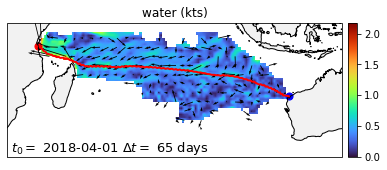

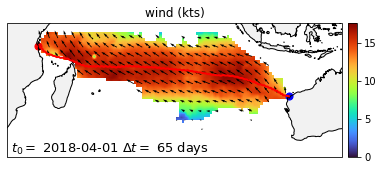

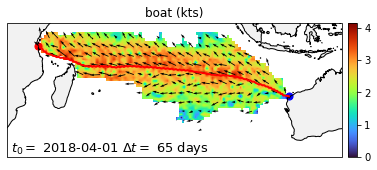

In [92]:
# plot wind water and boat speeds
%matplotlib inline
pVws = np.concatenate(Vws)
pVas = np.concatenate(Vas)
pVs  = np.concatenate(Vs)
pXs  = np.concatenate(Xs)

pintx = np.linspace(xlims[0],xlims[1],40*3)
pinty = np.linspace(ylims[0],ylims[1],15*3)

pintX,pintY = np.meshgrid(pintx,pinty)

idxkeep = np.zeros(pintX.shape).astype(bool)

_,_,ashape = AlphaShapeOpt(pXs)
bdom = pdom.intersection(ashape)

for j in range(pintX.shape[0]):
    for i in range(pintX.shape[1]):
        if Point([pintX[j,i],pintY[j,i]]).intersects(bdom):
            idxkeep[j,i]=True

pintuws = griddata(pXs, pVws[:,0], (pintX, pintY), method='linear')*tokts; pintuws[~idxkeep]=np.nan
pintvws = griddata(pXs, pVws[:,1], (pintX, pintY), method='linear')*tokts; pintvws[~idxkeep]=np.nan

pintuas = griddata(pXs, pVas[:,0], (pintX, pintY), method='linear')*tokts; pintuas[~idxkeep]=np.nan
pintvas = griddata(pXs, pVas[:,1], (pintX, pintY), method='linear')*tokts; pintvas[~idxkeep]=np.nan

pintus = griddata(pXs, pVs[:,0], (pintX, pintY), method='linear')*tokts; pintus[~idxkeep]=np.nan
pintvs = griddata(pXs, pVs[:,1], (pintX, pintY), method='linear')*tokts; pintvs[~idxkeep]=np.nan

titlem = '$t_0 = $ '+datet0.strftime('%Y-%m-%d')+' $\Delta t = $ '+str((datet-datet0).days)+' days'

qidx = 3;
fig,ax = pltbaseoverview(X0,Xt,title='water (kts)')
plt.quiver(pintX[::qidx,::qidx],pintY[::qidx,::qidx],pintuws[::qidx,::qidx],pintvws[::qidx,::qidx])

dx = (pintx[1]-pintx[0])/2.
dy = (pinty[1]-pinty[0])/2.
extent = [pintx[0]-dx, pintx[-1]+dx, pinty[0]-dy, pinty[-1]+dy]
im = plt.imshow(np.flip(np.sqrt(pintuws**2+pintvws**2),0), extent=extent,interpolation = 'bilinear',cmap='turbo',vmin=0)
fig,ax = plttarject(fig,ax,Nhist,Xs,Xt,hide_all=True)
cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()
plt.close()

fig,ax = pltbaseoverview(X0,Xt,title='wind (kts)')
plt.quiver(pintX[::qidx,::qidx],pintY[::qidx,::qidx],pintuas[::qidx,::qidx],pintvas[::qidx,::qidx])

dx = (pintx[1]-pintx[0])/2.
dy = (pinty[1]-pinty[0])/2.
extent = [pintx[0]-dx, pintx[-1]+dx, pinty[0]-dy, pinty[-1]+dy]
im      = plt.imshow(np.flip(np.sqrt(pintuas**2+pintvas**2),0), extent=extent,interpolation = 'bilinear',cmap='turbo',vmin=0)
fig,ax  = plttarject(fig,ax,Nhist,Xs,Xt,hide_all=True)
cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()
plt.close()

fig,ax = pltbaseoverview(X0,Xt,title='boat (kts)')
plt.quiver(pintX[::qidx,::qidx],pintY[::qidx,::qidx],pintus[::qidx,::qidx],pintvs[::qidx,::qidx])
dx = (pintx[1]-pintx[0])/2.
dy = (pinty[1]-pinty[0])/2.
extent = [pintx[0]-dx, pintx[-1]+dx, pinty[0]-dy, pinty[-1]+dy]
im = plt.imshow(np.flip(np.sqrt(pintus**2+pintvs**2),0), extent=extent,interpolation = 'bilinear',cmap='turbo',vmin=0)
fig,ax = plttarject(fig,ax,Nhist,Xs,Xt,hide_all=True)
cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()
plt.close()